In [15]:
import xarray as xr
import os
import xcdat
import numpy as np
from eofs.xarray import Eof
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [16]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily/monthly'
data_file = os.path.join(path, 'jra55_mon_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.bounds.add_missing_bounds(axes='T')
ds

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 705, level: 37, lat: 73, lon: 144, bnds: 2)
Coordinates:
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 584B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * time       (time) datetime64[ns] 6kB 1958-03-31 1958-04-30 ... 2016-11-30
Dimensions without coordinates: bnds
Data variables:
    u          (time, level, lat, lon) float32 1GB dask.array<chunksize=(28, 37, 73, 144), meta=np.ndarray>
    v          (time, level, lat, lon) float32 1GB dask.array<chunksize=(28, 37, 73, 144), meta=np.ndarray>
    t          (time, level, lat, lon) float32 1GB dask.array<chunksize=(28, 37, 73, 144), meta=np.ndarray>
    omega      (time, level, lat, lon) float32 1GB dask.array<chunksize=(28, 37, 73, 144), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] 11kB 1958-03-01 ... 2016-12-01

# DJF NAO

## Step 1: Calculate anomalies and subset data

- Calculate anomalies with pure monthly data
- Then take a slice at level=500hPa
- Subset to DJF months

In [17]:
var_anoms = ds.temporal.departures(data_var='u', freq='month', weighted=True)['u']
var_anoms = var_anoms.sel(level=500)
# var_anoms = var_anoms.resample(time='1QS-DEC').mean()
# var_anoms = var_anoms.sel(time=var_anoms.time.dt.month == 12)

var_anoms = var_anoms.sel(time=var_anoms.time.dt.month.isin([12,1,2]))
var_anoms = var_anoms.sel(lat=slice(90,0))
var_anoms

<xarray.DataArray 'u' (time: 174, lat: 37, lon: 144)> Size: 7MB
dask.array<getitem, shape=(174, 37, 144), dtype=float64, chunksize=(1, 37, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 90.0 87.5 85.0 82.5 80.0 ... 7.5 5.0 2.5 0.0
    level    float64 8B 500.0
  * time     (time) datetime64[ns] 1kB 1958-12-31 1959-01-31 ... 2016-02-29
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

## Step 2: Calculate EOFs

In [18]:
def eof_calc_alt(data,lats):

    coslat = np.cos(np.deg2rad(lats.values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[np.newaxis, :, np.newaxis] # position ':' at latitude

    solver = Eof(data, weights=wgts, center=True)

    eofs = solver.eofsAsCovariance(neofs=1)
    pc1 = solver.pcs(npcs=1) #, pcscaling=1)  # <---- removed because pcscaling=1 is unit variance : default is un-scaled

    variance_fractions = solver.varianceFraction(neigs=3)

    return eofs, pc1, variance_fractions, solver

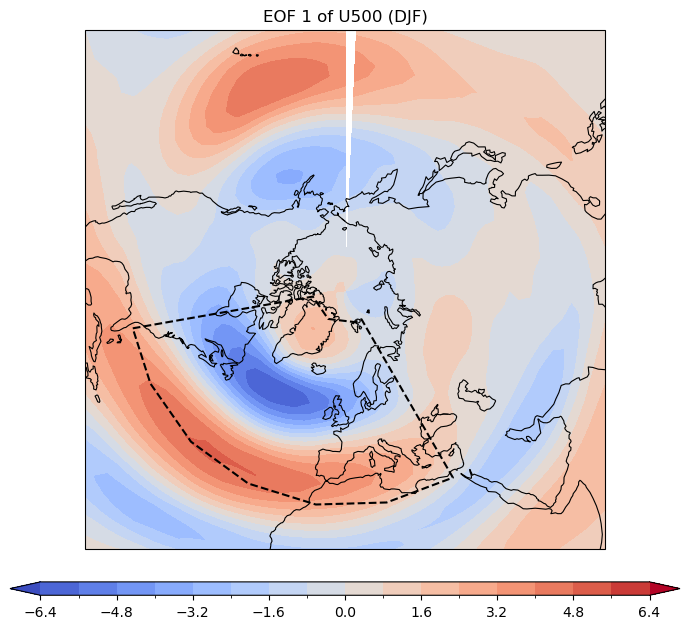

In [19]:
eofs, pc1, variance_fractions, solver = eof_calc_alt(var_anoms, var_anoms.lat)
eofs_shift = (
    eofs
    .assign_coords(lon=((eofs.lon + 180) % 360) - 180)
    .sortby('lon')
)

field = eofs_shift.sel(mode=0)                          # (lat, lon)

proj = ccrs.NorthPolarStereo()
fig = plt.figure(figsize=(7, 7))
ax  = plt.axes(projection=proj)
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# 1) EOF colour map (zorder=1 keeps it underneath)
pcm = field.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=21,
    cmap="coolwarm",
    extend="both",
    add_colorbar=False,
    zorder=1
)

# Coordinates of the box in lon‑lat (PlateCarree) space
box_lons = [-80, -80,  30,  30, -80]   # repeat the first point to close the path
box_lats = [ 30,  80,  80,  30,  30]

# Plot the outline on top of everything else
ax.plot(
    box_lons, box_lats,
    transform=ccrs.PlateCarree(),      # data are lon‑lat
    linewidth=1.5,
    linestyle="--",
    color="black",
    zorder=4                            # higher than contours & coastlines
)

# Land lines on top (higher zorder, or simply call AFTER the contourf)
ax.coastlines(linewidth=0.8, zorder=3)            # crisp black coastline

fig.colorbar(pcm, ax=ax, orientation="horizontal",
             pad=0.05, aspect=50)
plt.title("EOF 1 of U500 (DJF)")
plt.tight_layout()
plt.show()


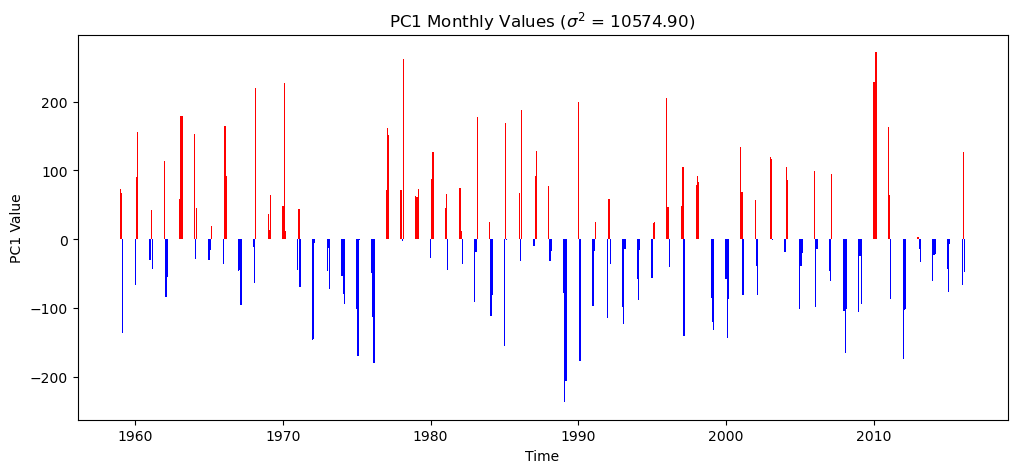

In [20]:
# Extract the pc1 data and select mode 0
data = pc1.sel(mode=0)
variance = data.var()

# Create a list of colors: red for positive (or zero) values, blue for negative values.
colors = ['red' if value >= 0 else 'blue' for value in data.values]
width = data.time[1] - data.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(data.time, data, color=colors, width=width)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title(f'PC1 Monthly Values ($\sigma^2$ = {variance.values:.2f})')
plt.show()

# Full Year NAO

## Step 1: Calculate anomalies and subset data

- Calculate anomalies with pure monthly data
- Then take a slice at level=500hPa
- Subset to DJF months

In [21]:
var_anoms = ds.temporal.departures(data_var='u', freq='month', weighted=True)['u']
var_anoms = var_anoms.sel(level=500)
# var_anoms = var_anoms.resample(time='1QS-DEC').mean()
# var_anoms = var_anoms.sel(time=var_anoms.time.dt.month == 12)

# var_anoms = var_anoms.sel(time=var_anoms.time.dt.month.isin([12,1,2]))
var_anoms = var_anoms.sel(lat=slice(90,0))
var_anoms

<xarray.DataArray 'u' (time: 705, lat: 37, lon: 144)> Size: 30MB
dask.array<getitem, shape=(705, 37, 144), dtype=float64, chunksize=(1, 37, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 90.0 87.5 85.0 82.5 80.0 ... 7.5 5.0 2.5 0.0
    level    float64 8B 500.0
  * time     (time) datetime64[ns] 6kB 1958-03-31 1958-04-30 ... 2016-11-30
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

## Step 2: Calculate EOFs

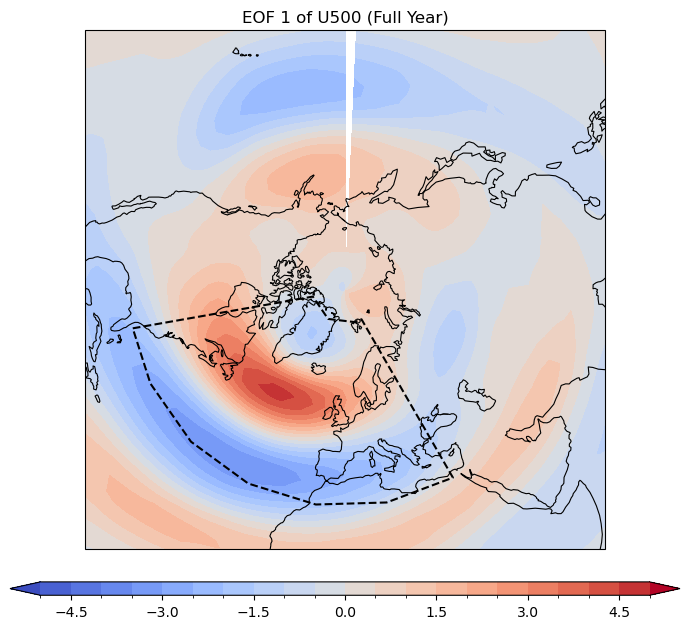

In [22]:
eofs_fy, pc1_fy, variance_fractions_fy, solver_fy = eof_calc_alt(var_anoms, var_anoms.lat)
eofs_shift_fy = (
    eofs_fy
    .assign_coords(lon=((eofs.lon + 180) % 360) - 180)
    .sortby('lon')
)

field = eofs_shift_fy.sel(mode=0)                          # (lat, lon)

proj = ccrs.NorthPolarStereo()
fig = plt.figure(figsize=(7, 7))
ax  = plt.axes(projection=proj)
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# 1) EOF colour map (zorder=1 keeps it underneath)
pcm = field.plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=21,
    cmap="coolwarm",
    extend="both",
    add_colorbar=False,
    zorder=1
)

# Coordinates of the box in lon‑lat (PlateCarree) space
box_lons = [-80, -80,  30,  30, -80]   # repeat the first point to close the path
box_lats = [ 30,  80,  80,  30,  30]

# Plot the outline on top of everything else
ax.plot(
    box_lons, box_lats,
    transform=ccrs.PlateCarree(),      # data are lon‑lat
    linewidth=1.5,
    linestyle="--",
    color="black",
    zorder=4                            # higher than contours & coastlines
)

# Land lines on top (higher zorder, or simply call AFTER the contourf)
ax.coastlines(linewidth=0.8, zorder=3)            # crisp black coastline

fig.colorbar(pcm, ax=ax, orientation="horizontal",
             pad=0.05, aspect=50)
plt.title("EOF 1 of U500 (Full Year)")
plt.tight_layout()
plt.show()


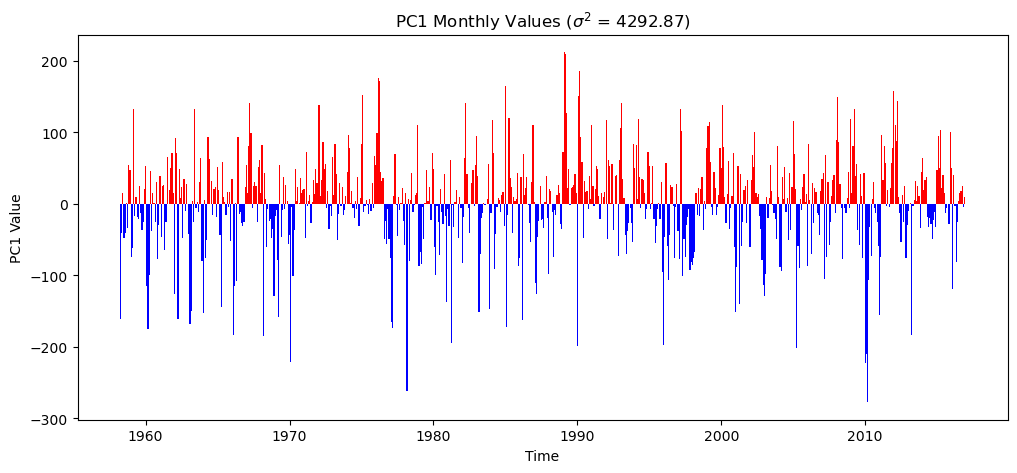

In [23]:
# Extract the pc1 data and select mode 0
data_fy = pc1_fy.sel(mode=0)
variance_fy = data_fy.var()

# Create a list of colors: red for positive (or zero) values, blue for negative values.
colors_fy = ['red' if value >= 0 else 'blue' for value in data_fy.values]
width_fy = data_fy.time[1] - data_fy.time[0]

plt.figure(figsize=(12, 5))
# Plot the data as a bar plot using matplotlib's plt.bar
plt.bar(data_fy.time, data_fy, color=colors_fy, width=width_fy)#, edgecolor='black')

# Optionally, add labels and title
plt.xlabel('Time')
plt.ylabel('PC1 Value')
plt.title(f'PC1 Monthly Values ($\sigma^2$ = {variance_fy.values:.2f})')
plt.show()

# Compare to real NAO

## Step 1: Import daily data and calculate anomalies

In [24]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
# ds = ds.sel(time=slice('1979-01', '2010-12-31'))
ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.bounds.add_missing_bounds(axes='T')

var_anoms = ds.temporal.departures(data_var='u', freq='day', weighted=True)['u']
var_anoms = var_anoms.sel(level=500)
var_anoms = var_anoms.sel(lat=slice(90,0))
var_anoms

<xarray.DataArray 'u' (time: 21445, lat: 37, lon: 144)> Size: 914MB
dask.array<getitem, shape=(21445, 37, 144), dtype=float64, chunksize=(1, 37, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 172kB 1958-03-01T09:00:00 ... 2016-11-30T0...
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 90.0 87.5 85.0 82.5 80.0 ... 7.5 5.0 2.5 0.0
    level    float64 8B 500.0
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       day
    weighted:   True

## Step 2: calculate EOFs

In [25]:
# eofs_day, pc1_day, variance_fractions_day, solver_day = eof_calc_alt(var_anoms, var_anoms.lat)

# # Create an xarray Dataset and save the computed outputs.
# eofs_ds = xr.Dataset(coords=eofs_day.coords)
# eofs_ds['eofs'] = eofs_day
# eofs_ds['pc1'] = pc1_day
# eofs_ds['variance_fractions'] = variance_fractions_day

# eofs_ds.to_netcdf('./data/jra55/jra55_daily_u500_eofs_nh.nc')

eofs_ds = xr.open_dataset('./data/jra55/jra55_daily_u500_eofs_nh.nc')
pc1 = -eofs_ds['pc1'].sel(mode=0)
pc1 = pc1.sel(time=slice('1979-01', '2010-12-31'))
pc1

<xarray.DataArray 'pc1' (time: 11680)> Size: 93kB
array([-139.65470573,  -71.8862512 ,  -31.05096619, ..., -157.89050827,
       -208.63203772, -134.05487436])
Coordinates:
    mode     int64 8B 0
  * time     (time) datetime64[ns] 93kB 1979-01-01T09:00:00 ... 2010-12-31T09...

## Step 3: calculate correlation

In [26]:
AO_path = '/home/links/ct715/data_storage/indices/AO'
csv_file = 'norm.daily.ao.cdas.z1000.19500101_current.csv'
AO_data = os.path.join(AO_path, csv_file)
df = pd.read_csv(AO_data)

# Suppose your DataFrame is named df and has columns: year, month, day, aao_index_cdas
# Create a datetime column
df['date'] = pd.to_datetime(df[['year','month','day']])
# df = df.loc['1978-03':'2011-02']
df = df[(df['date'] >= '1979-01-01') & (df['date'] <= '2010-12-31')]

# Sort by date just to be sure it's in ascending order
df = df.sort_values('date').reset_index(drop=True)
df

,year,month,day,ao_index_cdas,date
0,1979,1,1,-1.534920,1979-01-01
1,1979,1,2,-1.623296,1979-01-02
2,1979,1,3,-1.922149,1979-01-03
3,1979,1,4,-1.179706,1979-01-04
4,1979,1,5,0.333567,1979-01-05
...,...,...,...,...,...
11683,2010,12,27,-2.531653,2010-12-27
11684,2010,12,28,-2.776396,2010-12-28
11685,2010,12,29,-2.965967,2010-12-29
11686,2010,12,30,-3.017768,2010-12-30


In [27]:
# Create a mask that finds leap-day rows
leap_days = (df['date'].dt.month == 2) & (df['date'].dt.day == 29)
# Then invert that mask to keep everything else
df = df[~leap_days].copy()

# 1) Make sure df has a DateTimeIndex
df = df.set_index('date')  # Make 'date' the index
df.index = pd.to_datetime(df.index)  # Ensure it's a DateTimeIndex

# 2) Convert your pandas Series to an xarray DataArray
#    Let's say your PC1 is in df['pc1']:
ref_ao = df['ao_index_cdas'].to_xarray()  # pc1_da will be a 1D DataArray with dimension 'date'

# 3) Ensure your existing xarray DataArray 'da' has a matching time dimension
#    Optionally rename dimensions so both arrays share the same dimension name:
#    (some data might have 'time', the other might have 'date'; unify them)
ref_ao = ref_ao.rename({'date': 'time'})  
# Now pc1_da and da both have dimension 'time' (assuming 'da' was also 'time').
ref_ao['time'] = ref_ao['time'].dt.strftime('%Y-%m-%d')

ao = pc1.sel(time=slice('1958-03', '2016-11')) #.values
ao['time'] = ao['time'].dt.strftime('%Y-%m-%d')

# calculate correlation after ensuring both DataArrays have the same time dimension
ref_ao_aligned, fy_aligned = xr.align(ref_ao, ao, join='inner')
r = xr.corr(ref_ao_aligned, fy_aligned, dim='time')
print("Correlation:", r.values)

Correlation: 0.6618622409528889


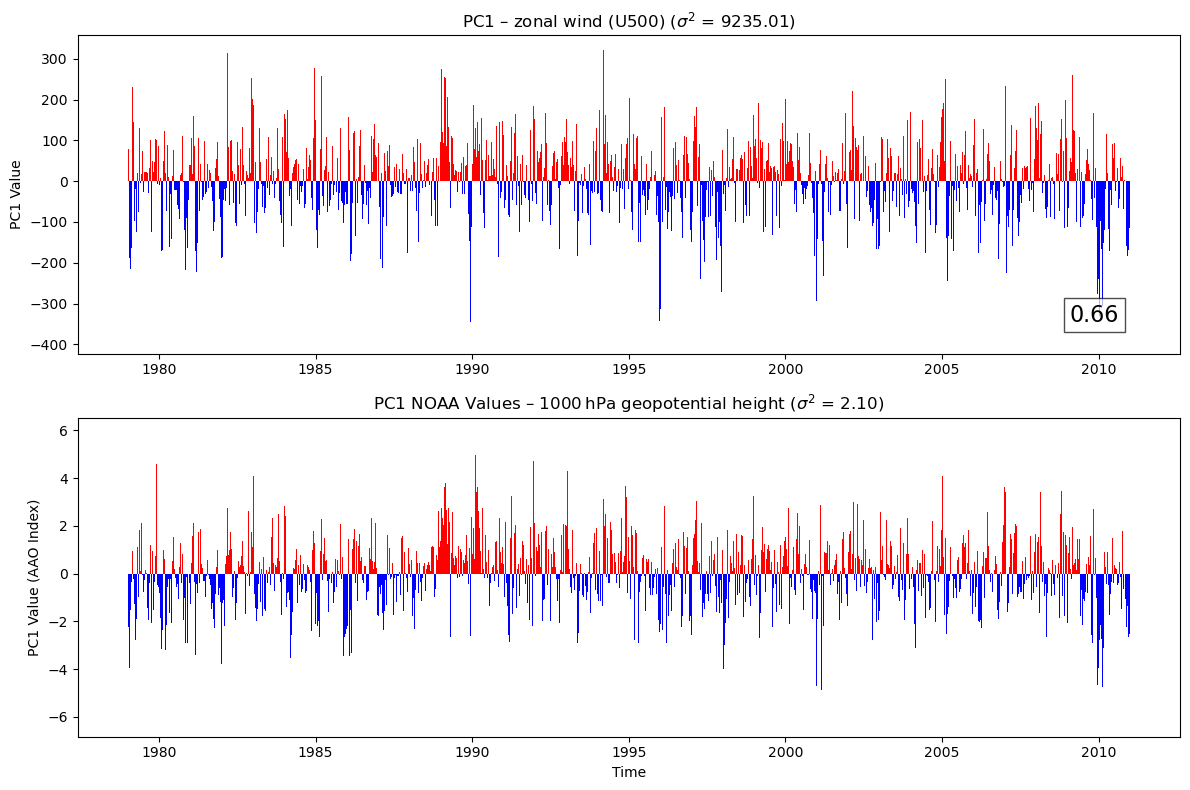

In [28]:
# ── Convert the coordinate once ───────────────────────────────
ao_times = pd.to_datetime(ao.time)        # -> dtype='datetime64[ns]'
ao_vals  = ao.values                      # y‑data

# A 1‑day bar looks good for daily data
bar_width = 1                               # units = “days” on a date axis

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

# ---- panel 1 -------------------------------------------------
colors = ['red' if v >= 0 else 'blue' for v in ao_vals]

ax1.bar(ao_times, ao_vals, color=colors, width=bar_width)
ax1.set_ylabel('PC1 Value')
ax1.set_title(f'PC1 – zonal wind (U500) ($\\sigma^2$ = {ao.var():.2f})')

ax1.text(0.9, 0.1,
         f'{r.values.round(2)}',
         transform=ax1.transAxes,
         fontsize=16,
         bbox=dict(facecolor='white', alpha=0.7))

# ---- panel 2 -------------------------------------------------
# Make sure the “time” column is already datetime64[ns]
pc1_times = pd.to_datetime(ref_ao['time'])
pc1_vals  = ref_ao.values
colors_df = ['red' if v >= 0 else 'blue' for v in pc1_vals]

if len(pc1_times) > 1:
    bar_width_df = (pc1_times[1] - pc1_times[0]).days
else:
    bar_width_df = 1

ax2.bar(pc1_times, pc1_vals, color=colors_df, width=bar_width_df)
ax2.set_xlabel('Time')
ax2.set_ylabel('PC1 Value (AAO Index)')
ax2.set_title(f'PC1 NOAA Values – 1000 hPa geopotential height ($\\sigma^2$ = {ref_ao.var():.2f})')

# Optional: prettier date formatting
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mdates.YearLocator(5))   # tick every 5 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()
